In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sn
from matplotlib import pyplot as plt
import statsmodels.api as sm
from pylab import rcParams

In [2]:
#Read the csv file
data=pd.read_csv('data.csv',parse_dates=['mkt_datetime'])

In [3]:
data.head(2)

,mkt_datetime,int_nuc_sch,int_gas_sch,int_hyd_sch,int_win_sch,imp_mic_sch,imp_new_sch,imp_que_sch,ont_avg_dem,exp_mic_sch,exp_new_sch,exp_que_sch,ont_ene
0,2020-01-01 00:00:00,11554,216,2857,2113,0,0,9,13305,-800,-1285,-1273,0.0
1,2020-01-01 01:00:00,11554,216,2834,1595,0,0,9,12870,-800,-1285,-1273,0.0


In [4]:
#Variables for training
cols = list(data)[0:13]
df=data[cols]
df.set_index('mkt_datetime', inplace=True)

In [5]:
df.head(2)

,int_nuc_sch,int_gas_sch,int_hyd_sch,int_win_sch,imp_mic_sch,imp_new_sch,imp_que_sch,ont_avg_dem,exp_mic_sch,exp_new_sch,exp_que_sch,ont_ene
mkt_datetime,,,,,,,,,,,,
2020-01-01 00:00:00,11554,216,2857,2113,0,0,9,13305,-800,-1285,-1273,0.0
2020-01-01 01:00:00,11554,216,2834,1595,0,0,9,12870,-800,-1285,-1273,0.0


In [7]:
monthly_avg_price = df['ont_ene'].resample('MS').mean()

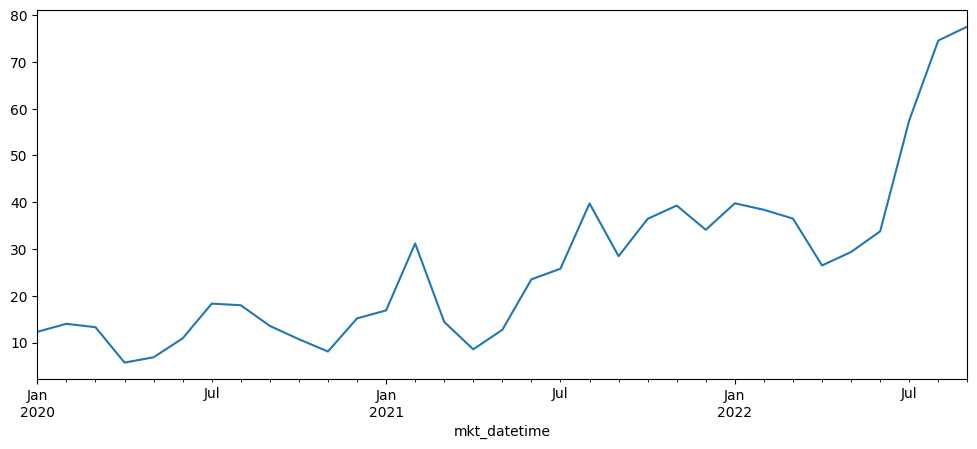

In [8]:
rcParams['figure.figsize']=12,4.8
monthly_avg_price.plot()
plt.show()

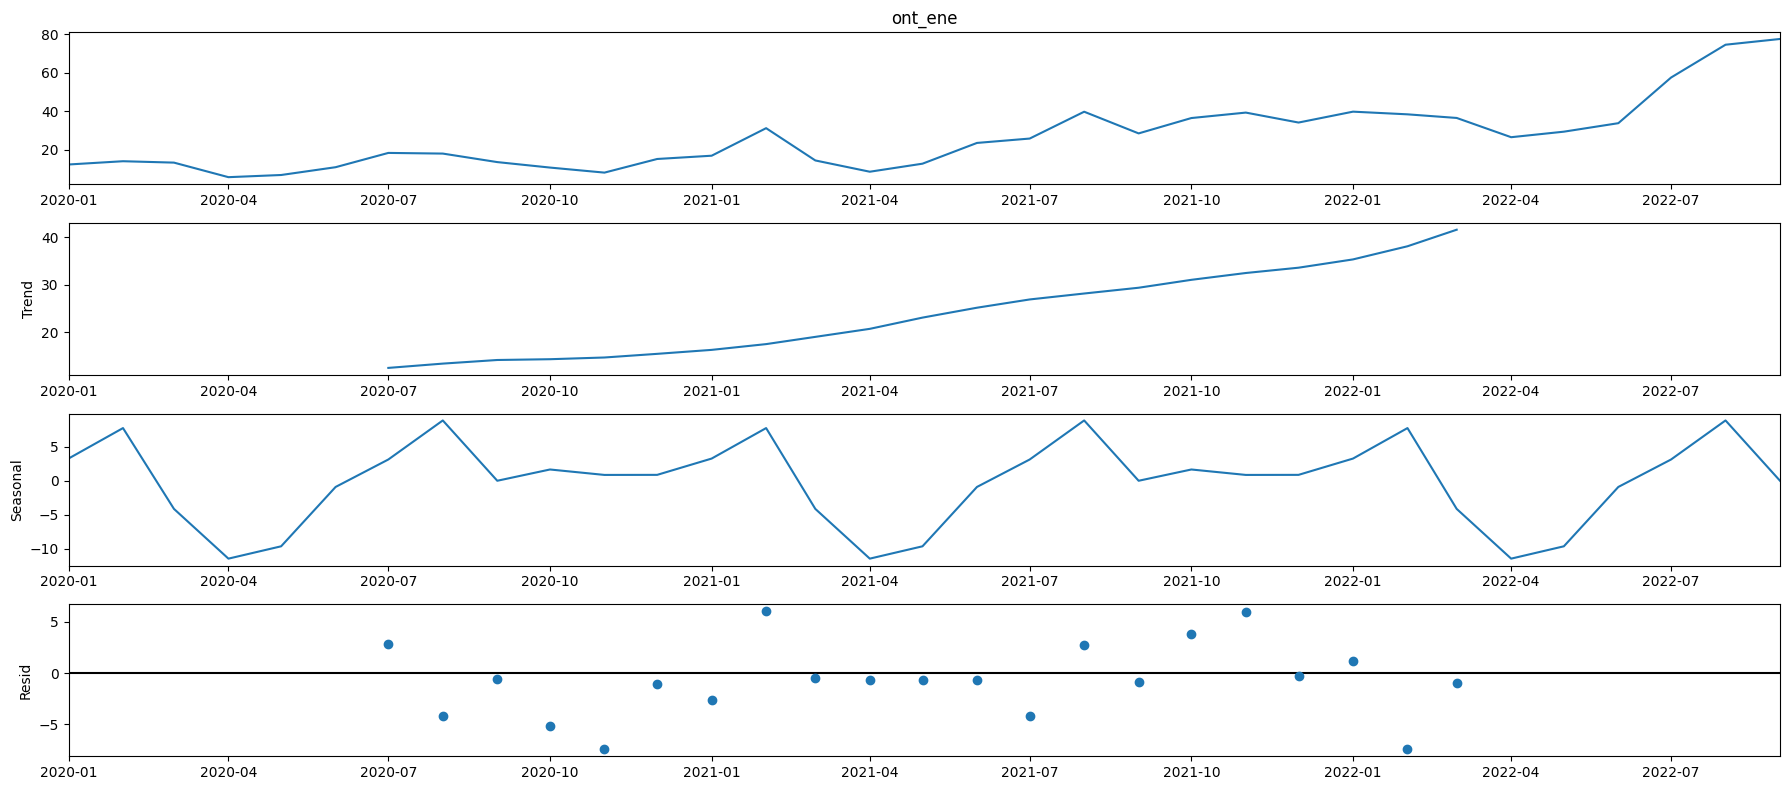

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(monthly_avg_price, model='additive')
fig = decomposition.plot()
plt.show()

In [12]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
df_scaled = sc.fit_transform(df)

In [13]:
print(df_scaled[0])

[0.90782302 0.0141516  0.20030311 0.46185792 0.         0.
 0.00349108 0.227      0.53188999 0.26571429 0.42241379 0.        ]


In [18]:
# split into train and test sets
# train_size = int(len(uni_df) * 0.8)
train_size=(365+366)*24  # 2020 - 2021 dataset as training set
test_size = len(df) - train_size
train, test = df_scaled[0:train_size,:], df_scaled[train_size:len(df),:]

In [19]:
train_size

17544

In [20]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), :]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 11])
    return np.array(data_x), np.array(data_y)

In [21]:
# reshape into X=t and Y=t+1
look_back = 48 # past 48 hours data to be used for prediction
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

In [22]:
# groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# i = 1
# # plot each column
# values=uni_df.values
# plt.figure(figsize=(14, 10))
# for group in groups:
# 	plt.subplot(len(groups), 1, i)
# 	plt.plot(values[:1000, group])
# 	plt.title(uni_df.columns[group], y=0.5, loc='right')
# 	i += 1
# plt.show()

In [24]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 60)            17520     
                                                                 
 dropout (Dropout)           (None, 48, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 48, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 40, batch_size = 24,validation_data=(X_test, Y_test), callbacks=[reduce_lr], shuffle=False)

Epoch 1/40
729/729 [==============================] - 74s 90ms/step - loss: 0.0661 - val_loss: 0.1625 - lr: 0.0010
Epoch 2/40
729/729 [==============================] - 73s 101ms/step - loss: 0.0525 - val_loss: 0.1437 - lr: 0.0010
Epoch 3/40
729/729 [==============================] - 61s 84ms/step - loss: 0.0468 - val_loss: 0.1282 - lr: 0.0010
Epoch 4/40
729/729 [==============================] - 62s 85ms/step - loss: 0.0441 - val_loss: 0.1236 - lr: 0.0010
Epoch 5/40
729/729 [==============================] - 65s 89ms/step - loss: 0.0427 - val_loss: 0.1216 - lr: 0.0010
Epoch 6/40
729/729 [==============================] - 74s 101ms/step - loss: 0.0414 - val_loss: 0.1174 - lr: 0.0010
Epoch 7/40
729/729 [==============================] - 75s 102ms/step - loss: 0.0406 - val_loss: 0.1108 - lr: 0.0010
Epoch 8/40
729/729 [==============================] - 72s 99ms/step - loss: 0.0406 - val_loss: 0.1116 - lr: 0.0010
Epoch 9/40
729/729 [==============================] - 82s 113ms/step - loss: 

In [26]:
regressor.save('lstm_multi_model_v2')

INFO:tensorflow:Assets written to: lstm_multi_model_v2/assets


INFO:tensorflow:Assets written to: lstm_multi_model_v2/assets


In [69]:
# regressor = tf.keras.models.load_model('lstm_multi_model4')

In [27]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

187/187 [==============================] - 6s 29ms/step


In [28]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [29]:
colNames=list(df)
colName='ont_ene'

In [30]:
# invert predictions
train_predict = invTransform(sc,train_predict,colName,colNames)
Y_train_inv = invTransform(sc,Y_train,colName,colNames)
test_predict = invTransform(sc,test_predict,colName,colNames)
Y_test_inv = invTransform(sc,Y_test,colName,colNames)

Train Mean Absolute Error: 4.732325007763879
Train Root Mean Squared Error: 8.022190711194362
Test Mean Absolute Error: 9.47428565242744
Test Root Mean Squared Error: 14.252743408721944


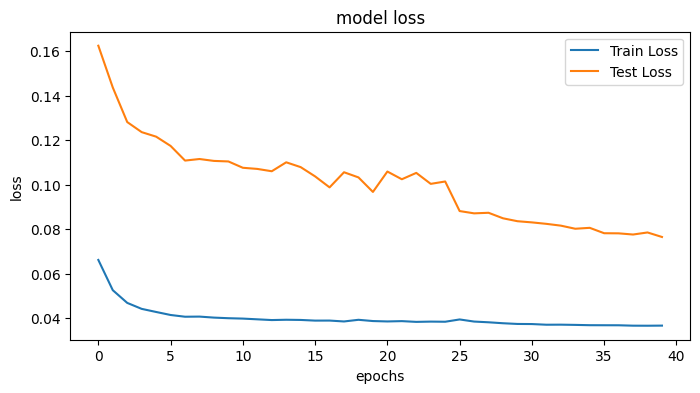

In [31]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv, test_predict)))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

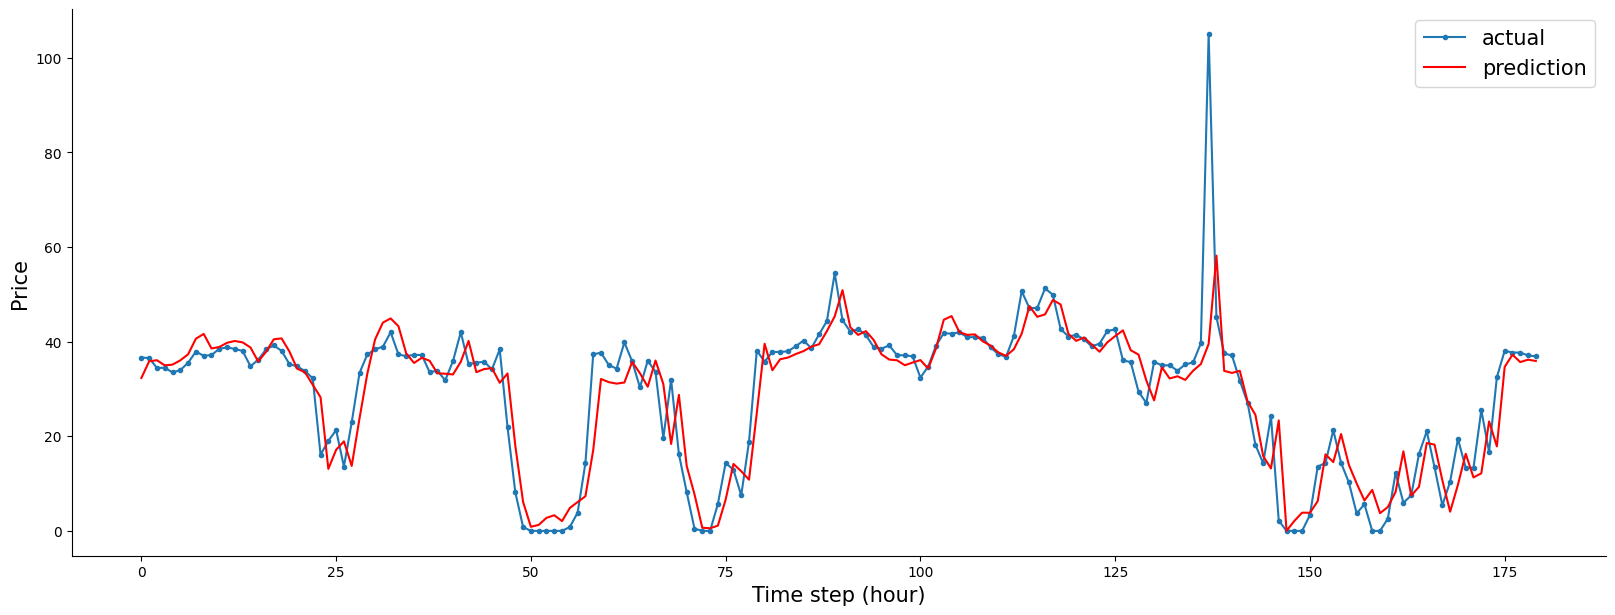

In [62]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test_inv[0:180], marker='.', label="actual")
plt.plot(aa, test_predict[0:180], 'r', label="prediction")
# plt.plot(aa, lstm_20[2000:2180], 'green', label="prediction")
plt.tight_layout()
sn.despine(top=True)
# plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step (hour)', size=15)
plt.legend(fontsize=15)
plt.show();

(5975,)

In [63]:
from sklearn.metrics import mean_squared_error, r2_score
print('R2 Score: ', r2_score(Y_test_inv, test_predict))
print('R2 Score: ', r2_score(Y_train_inv, train_predict))

R2 Score:  0.7681301612538662
R2 Score:  0.7819157099244441


In [47]:
d={'Timestamp':data.mkt_datetime[17592:23567],'original':Y_test_inv,'predicted':test_predict}
price_df=pd.DataFrame(d)

In [48]:
final=price_df.round(2)

In [49]:
final.to_csv('val_predictions3.csv',index=False)

In [ ]:
regressor = Sequential()

regressor.add(GRU(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 60))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
regressor.summary()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 24,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

In [ ]:
regressor.save('gru_multi_model')

In [ ]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [ ]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [ ]:
colNames=list(uni_df)
colName='ont_ene'

In [ ]:
# invert predictions
train_predict = invTransform(sc,train_predict,colName,colNames)
Y_train_inv = invTransform(sc,Y_train,colName,colNames)
test_predict = invTransform(sc,test_predict,colName,colNames)
Y_test_inv = invTransform(sc,Y_test,colName,colNames)

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv, test_predict)))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test_inv[1000:1180], marker='.', label="actual")
plt.plot(aa, test_predict[1000:1180], 'r', label="prediction")
plt.tight_layout()
sn.despine(top=True)
# plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step (hour)', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print('R2 Score: ', r2_score(Y_test_inv, test_predict))